## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt
from scipy.stats import circmean

from sklearn.metrics import r2_score
from sklearn.utils.extmath import randomized_svd as rsvd

from pydmd import RDMD

from utils import tic, toc, generate_color_gradient

%matplotlib inline

In [2]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [3]:
def plot_allen(ax):
    allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']
    for i in range(len(allen_ccf)):
        temp1 = allen_ccf[i]
        ax.plot(temp1[:,0],temp1[:,1],'w',lw=.5)

In [4]:
def circ_corr(angles1, angles2):
    """Compute the circular correlation coefficient between two sets of angles."""
    mean_angle1 = circmean(angles1,nan_policy='omit')
    mean_angle2 = circmean(angles2,nan_policy='omit')
    
    sin_diff1 = np.sin(angles1 - mean_angle1)
    sin_diff2 = np.sin(angles2 - mean_angle2)
    
    numerator = np.nansum(sin_diff1 * sin_diff2)
    denominator = np.sqrt(np.nansum(sin_diff1 ** 2) * np.nansum(sin_diff2 ** 2))
    
    return numerator / denominator

## Load and preprocess data

In [5]:
data_dir = '/home/ryanr/widefield'
outdir = '/home/ryanr/Allen/arousal_final/model_predictions'
figdir = '/home/ryanr/Allen/arousal_final/figs'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [6]:
from numpy.random import seed
seed(1)

## Analysis

In [7]:
## Set modeling parameters

subjects = [4,5,6,7,8,9,10]
Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 4 # number of latent dimensions used for VAE

# DMD

In [8]:
modality = 'jrgeco'
num_modes = 2
scores = np.zeros([len(subjects),2])
modes = np.zeros([len(subjects),10400,3,num_modes],dtype=np.complex_)

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]
        
    ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')
    ytest_hat1 = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
    ytest_hat2 = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')
    
    dmd1 = RDMD(svd_rank=num_modes,seed=1,oversampling=5,power_iters=1)
    dmd2 = RDMD(svd_rank=num_modes,seed=1,oversampling=5,power_iters=1)
    dmd3 = RDMD(svd_rank=num_modes,seed=1,oversampling=5,power_iters=1)
    
    dmd1.fit(ytest.T)
    dmd2.fit(ytest_hat2.T)
    dmd3.fit(ytest_hat1.T)
    
    scores[s,0] = np.abs(circ_corr(np.angle(dmd1.modes[:,0]),np.angle(dmd3.modes[:,0])))
    scores[s,1] = np.abs(circ_corr(np.angle(dmd1.modes[:,0]),np.angle(dmd2.modes[:,0])))
    
    modes[s,:,0,:] = dmd1.modes.copy()
    modes[s,:,1,:] = dmd2.modes.copy()
    modes[s,:,2,:] = dmd3.modes.copy()

    toc()
    
np.save(outdir + '/dmd_modes_grp.npy', modes)

/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1.9264305646690988e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 5.8615969474812985e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 8.89494397421693e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Elapsed time is 800.7787892818451 seconds.


/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4.659127920086944e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 5.225921900117662e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 9.647229898883655e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Elapsed time is 800.6959149837494 seconds.


/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2.460912595961884e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4.491298805634074e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 7.821324611993409e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Elapsed time is 800.6254346370697 seconds.


/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2.8494447053965445e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4.843775475180504e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 7.612808902088031e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Elapsed time is 800.8328416347504 seconds.


/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 3.4893575938211123e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4.468896233648647e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 8.652704586685482e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Elapsed time is 801.2068433761597 seconds.


/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 3.167989738255688e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 5.877339512290423e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 6.975964599593374e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Elapsed time is 800.2643818855286 seconds.


/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 3.4323526814822784e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4.482637483918985e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/ryanr/anaconda3/envs/swdb2022/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 9.993994388217072e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Elapsed time is 800.7003002166748 seconds.


In [9]:
modes = np.load(outdir + '/dmd_modes_grp.npy')
scores = np.zeros([len(subjects),2])
for s in range(len(subjects)):
    scores[s,0] = np.abs(circ_corr(np.angle(modes[s,:,0,0]),np.angle(modes[s,:,2,0])))
    scores[s,1] = np.abs(circ_corr(np.angle(modes[s,:,0,0]),np.angle(modes[s,:,1,0])))

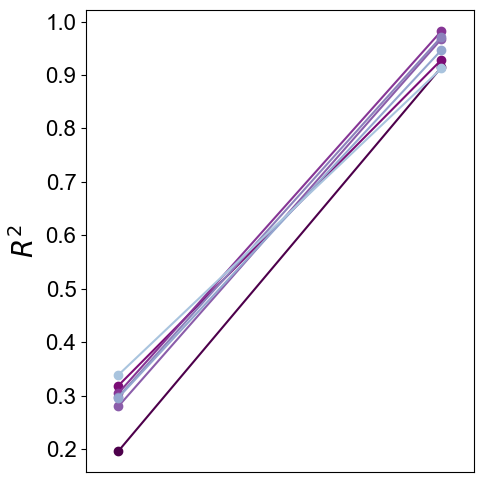

In [10]:
line_colors = generate_color_gradient(len(subjects)+3,modality)
fig, ax = plt.subplots(figsize=(5,6))
for i in range(len(subjects)):
    plt.plot(scores[i,[0,1]].T,  markersize=12, marker = '.', color=line_colors[i])
    
ax.set_xticks([])
ax.set_xlim([-.1,1.1])
ax.set_ylabel('$R^2$', fontsize=20)

plt.savefig(figdir + '/dmd_corrs.pdf', dpi=300, transparent=True)

plt.show()

## Visualize modes

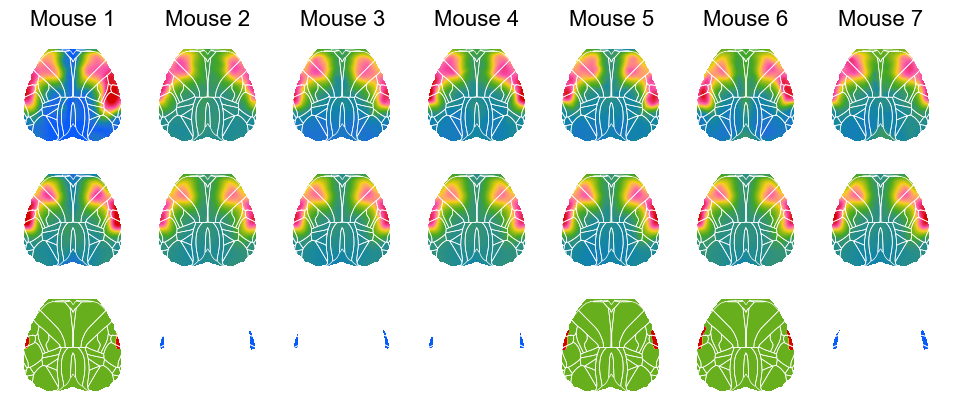

In [11]:
temp = np.zeros((16384,1), dtype=np.single)

fig, axes = plt.subplots(3,len(subjects),sharex='col',figsize=(9.42,5),layout='compressed')

for s in range(len(subjects)):
    
    angles = np.angle(modes[s,:,:,0])
    angles = angles - np.angle(np.mean(np.exp(1j*angles),axis=0))
    angles = np.angle(np.exp(1j * angles))

    for i, ax in enumerate(axes[:,s]):
        temp = np.zeros((16384,1), dtype=np.single)
        temp[mask_long] = angles[:,i].reshape(-1,1)
        temp = np.ma.masked_where(temp==0, temp)
        temp = temp.reshape(128,128,order='F')
        im = ax.imshow(temp, vmin=-np.pi/6, vmax=np.pi/2, cmap=cc.cm.CET_R3)
        
        if i==0:
            ax.set_title('Mouse ' + str(s+1), fontsize=16)

        if np.mod(i,len(subjects))==len(subjects)-1:
            cbar=plt.colorbar(im, ax=ax, aspect=10, shrink=.7)

        plot_allen(ax)
        ax.axis('off')
    
plt.show()

### Pick one for paper

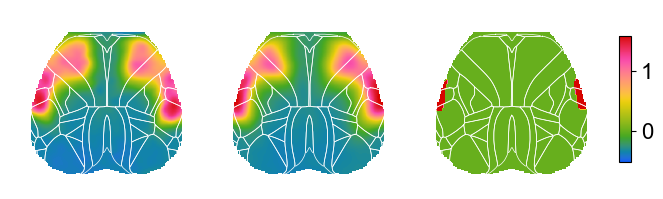

In [12]:
temp = np.zeros((16384,1), dtype=np.single)

angles = np.angle(modes[4,:,:,0])
angles = angles - np.angle(np.mean(np.exp(1j*angles),axis=0))
angles = np.angle(np.exp(1j * angles))

fig, axes = plt.subplots(1,3,sharex='col',figsize=(9.42,1.88),layout='compressed')

axes = axes.flatten()
for i, ax in enumerate(axes):
    temp = np.zeros((16384,1), dtype=np.single)
    temp[mask_long] = angles[:,i].reshape(-1,1)
    temp = np.ma.masked_where(temp==0, temp)
    temp = temp.reshape(128,128,order='F')
    im = ax.imshow(temp, vmin=-np.pi/6, vmax=np.pi/2, cmap=cc.cm.CET_R3)
    
    if i==2:
        cbar=plt.colorbar(im, ax=ax, aspect=10, shrink=.7)
    
    plot_allen(ax)
    ax.axis('off')
    
plt.savefig(figdir + '/dmd_modes.pdf', dpi=300, transparent=True)
    
plt.show()